In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-flare-data/val.csv
/kaggle/input/solar-flare-data/train.csv
/kaggle/input/solar-flare-data/test.csv
/kaggle/input/solar-flare-data/solar_flare_data.csv


# ******Dataset Overview******

In [2]:
#  Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load Datasets
train_path = "/kaggle/input/solar-flare-data/train.csv"
val_path = "/kaggle/input/solar-flare-data/val.csv"
test_path = "/kaggle/input/solar-flare-data/test.csv"
df_all = pd.read_csv("/kaggle/input/solar-flare-data/solar_flare_data.csv") 

df_train = pd.read_csv(train_path)
df_val= pd.read_csv(val_path)
df_test= pd.read_csv(test_path)

In [3]:
# Display dataset shapes before processing
print("Train Dataset Shape:", df_train.shape)
print("Validation Dataset Shape:", df_val.shape)
print("Test Dataset Shape:", df_test.shape)

Train Dataset Shape: (31957, 7)
Validation Dataset Shape: (10653, 7)
Test Dataset Shape: (10653, 7)


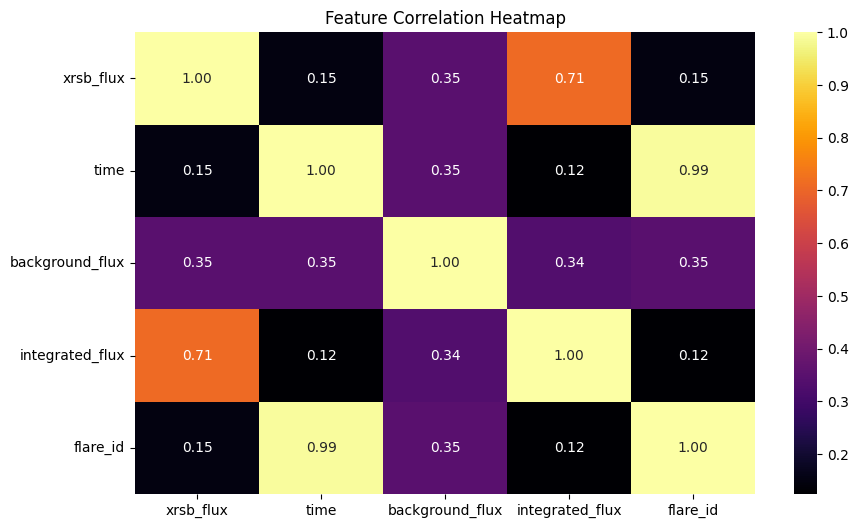

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.corr(numeric_only=True), annot=True, fmt=".2f", cmap="inferno")
plt.title("Feature Correlation Heatmap")
plt.show()


In [5]:
# Drop infinite and missing values in critical columns
critical_cols = ["xrsb_flux", "background_flux", "integrated_flux", "flare_class"]
df_all.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(subset=critical_cols, inplace=True)

df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [6]:
# Convert time to datetime and extract year
df_train['time'] = pd.to_datetime(df_train['time'])
df_val['time'] = pd.to_datetime(df_val['time'])
df_test['time'] = pd.to_datetime(df_test['time'])

df_train['year'] = df_train['time'].dt.year
df_val['year'] = df_val['time'].dt.year
df_test['year'] = df_test['time'].dt.year

In [7]:
# 70-15-15 random split
train_all, temp = train_test_split(df_all, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(temp, test_size=0.5, random_state=42)

In [8]:
# Apply log1p transformation to the target variable for all splits
y_train = np.log1p(df_train["integrated_flux"])

X_val = df_val.drop(columns=["integrated_flux"])
y_val = np.log1p(df_val["integrated_flux"])

X_test = df_test.drop(columns=["integrated_flux"])
y_test = np.log1p(df_test["integrated_flux"])  # If available for evaluation

In [9]:
# remove_outliers
def remove_outliers_lof_full(df, numeric_features, contamination=0.01):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    outliers = lof.fit_predict(df[numeric_features])
    return df[outliers == 1]  

# List of numeric features used for outlier detection
numeric_features = ["xrsb_flux", "background_flux", "integrated_flux"]

# Re-read raw train file (since earlier df_train may be modified/damaged)
df_train = pd.read_csv("/kaggle/input/solar-flare-data/train.csv")
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_train.dropna(subset=numeric_features + ['flare_class'], inplace=True)

# Apply outlier removal
df_train = remove_outliers_lof_full(df_train, numeric_features)


In [10]:
#Apply log1p transformation only to skewed features to stabilize variance
def log_transform(df, features):
    df[features] = np.log1p(df[features])
    return df

df_train = log_transform(df_train, ["xrsb_flux"])
df_val = log_transform(df_val, ["xrsb_flux"])
df_test = log_transform(df_test, ["xrsb_flux"])


**feature engineering**

In [11]:
from sklearn.preprocessing import LabelEncoder

# Function to create new features
def engineer_features(df):
    df["flux_ratio"] = df["xrsb_flux"] / (df["background_flux"] + 1e-9)  # Avoid division by zero

    # Encode flare_class (check if it exists first)
    if "flare_class" in df.columns:
        le_flare = LabelEncoder()
        df["flare_class_encoded"] = le_flare.fit_transform(df["flare_class"].astype(str))

    # Encode 'status' column if it's categorical
    if "status" in df.columns and df["status"].dtype == 'object':
        le_status = LabelEncoder()
        df["status_encoded"] = le_status.fit_transform(df["status"].astype(str))

    return df

# Apply to train and val
df_train = engineer_features(df_train)
df_val = engineer_features(df_val)


In [12]:
features = ["xrsb_flux", "background_flux", "flux_ratio", "flare_class_encoded", "status_encoded"]

In [13]:
# Save preprocessed files
df_train.to_csv("preprocessed_train.csv", index=False)
df_val.to_csv("preprocessed_val.csv", index=False)
df_test.to_csv("preprocessed_test.csv", index=False)

In [14]:
# Display dataset info and first few rows
for name, dataset in zip(["Train", "Validation", "Test"], [df_train, df_val, df_test]):
    print(f"\n{name} Set:")
    print(dataset.info())
    print(dataset.head())


Train Set:
<class 'pandas.core.frame.DataFrame'>
Index: 8627 entries, 5 to 31950
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   xrsb_flux            8627 non-null   float64
 1   status               8627 non-null   object 
 2   time                 8627 non-null   float64
 3   background_flux      8627 non-null   float64
 4   flare_class          8627 non-null   object 
 5   integrated_flux      8627 non-null   float64
 6   flare_id             8627 non-null   int64  
 7   flux_ratio           8627 non-null   float64
 8   flare_class_encoded  8627 non-null   int64  
 9   status_encoded       8627 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 741.4+ KB
None
    xrsb_flux      status         time  background_flux flare_class  \
5    0.000003  EVENT_PEAK  771589080.0     1.970604e-06        C2.8   
7    0.000003  EVENT_PEAK  692796300.0     7.824030e-07        C3.0   
8  

# *****Prepare Data for Modeling*****

1. **Random Forest Model**

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load preprocessed data
df_train = pd.read_csv("/kaggle/working/preprocessed_train.csv")
df_val = pd.read_csv("/kaggle/working/preprocessed_val.csv")

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [17]:
# Drop rows with NaN if any
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)

In [18]:
# Define updated features and target
features = ["xrsb_flux", "background_flux", "flux_ratio", "flare_class_encoded", "status_encoded"]
target = "integrated_flux"

X_train = df_train[features]
y_train = df_train[target]

X_val = df_val[features]
y_val = df_val[target]

In [19]:
# Initialize and train Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

2. **XGBoost for Regression**

In [20]:
#XGBoost Regressor – Feature & Target Preparation
from xgboost import XGBRegressor
features = ["xrsb_flux", "background_flux", "flux_ratio", "flare_class_encoded", "status_encoded"]

X_train = df_train[features]
y_train = df_train["integrated_flux"]

X_val = df_val[features]
y_val = df_val["integrated_flux"]


In [21]:
# Initialize and train XGBoost
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predict and evaluate
y_pred_xgb = xgb.predict(X_val)
r2_xgb = r2_score(y_val, y_pred_xgb)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)

print(f"XGBoost R² Score: {r2_xgb:.4f}")
print(f"XGBoost MSE: {mse_xgb:.6f}")

XGBoost R² Score: 0.8113
XGBoost MSE: 0.000009


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


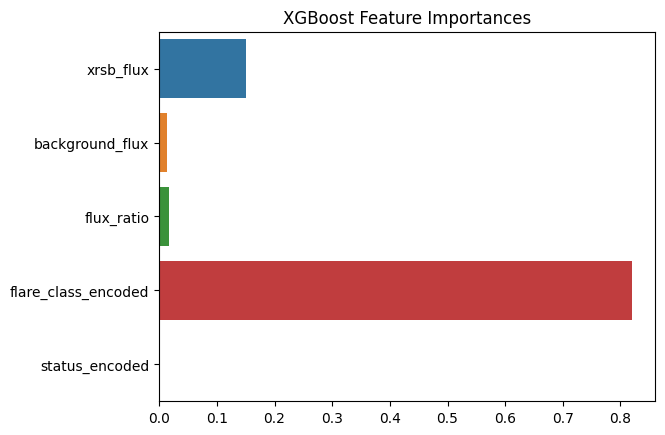

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from XGBoost
importances = xgb.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("XGBoost Feature Importances")
plt.show()

**bar plot of R² and MSE for Random Forest vs XGBoost**

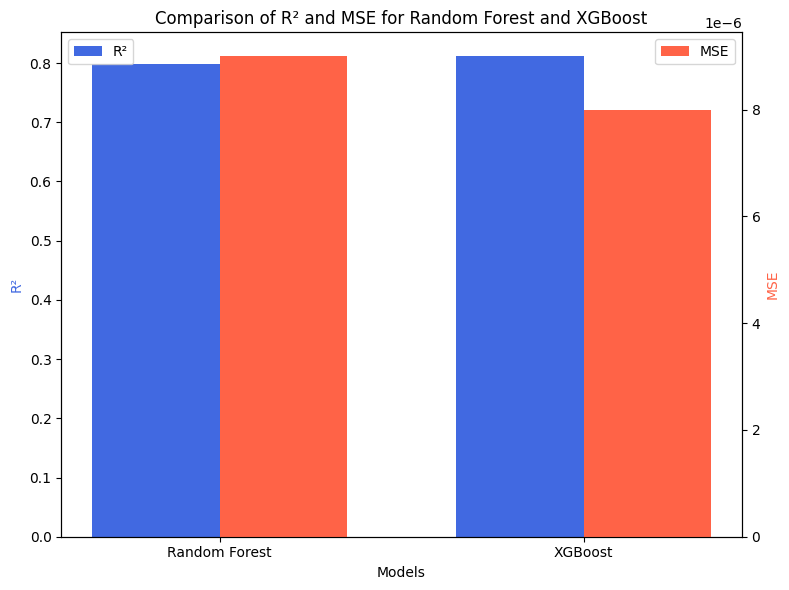

In [24]:
#  R² and MSE values for Random Forest and XGBoost
r2_rf = 0.7983
r2_xgb = 0.8113
mse_rf = 0.000009
mse_xgb = 0.000008

# Create a bar plot for R² and MSE
labels = ['Random Forest', 'XGBoost']
r2_scores = [r2_rf, r2_xgb]
mse_scores = [mse_rf, mse_xgb]

# Set up the bar positions
x = np.arange(len(labels))

# Plot R² values
fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar width for R² and MSE
width = 0.35

# Create the bars for R²
rects1 = ax1.bar(x - width/2, r2_scores, width, label='R²', color='royalblue')

# Create the bars for MSE (use a secondary y-axis for better scaling)
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, mse_scores, width, label='MSE', color='tomato')

# Labeling the axes
ax1.set_ylabel('R²', color='royalblue')
ax2.set_ylabel('MSE', color='tomato')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Models')

# Add title and legends
ax1.set_title('Comparison of R² and MSE for Random Forest and XGBoost')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


*hyperparameters for XGBoost and boost*

In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Define parameter grid
param_dist = {
    "n_estimators": [200, 300, 500, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "max_depth": [3, 5, 7, 9, 10],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize base model
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring="r2",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best model from search
best_xgb = random_search.best_estimator_

# Predict and evaluate
y_pred_best = best_xgb.predict(X_val)
r2_best = r2_score(y_val, y_pred_best)
mse_best = mean_squared_error(y_val, y_pred_best)

print("\n Best Parameters:")
print(random_search.best_params_)

print(f"\n Updated XGBoost R² Score: {r2_best:.4f}")
print(f"Updated XGBoost MSE: {mse_best:.6f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits

 Best Parameters:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

 Updated XGBoost R² Score: 0.8298
Updated XGBoost MSE: 0.000008
